In [45]:
from __future__ import print_function

In [46]:
import numpy as np
from scipy.linalg import expm
import random

class move_gym():
    def __init__(self):
        self.scope = 2.0
        self.states = 6
        self.actions = 4
    def reset( self, s = [] ):
        if np.array( s ).shape[0] == 0:

            self.obstacle_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.obstacle_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1

            self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1  
            while ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 ):
                self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
                self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1      

            self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            while (  ( abs(self.obstacle_x-self.target_x) < 1.05 ) & ( abs(self.obstacle_y-self.target_y) < 1.05 )  ) |\
             (  ( abs(self.move_x-self.target_x) < 1.05 ) & ( abs(self.move_y-self.target_y) < 1.05 )  ):
                self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
                self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1        

        else:
            self.obstacle_x=s[0]
            self.obstacle_y=s[1]
            self.target_x=s[2]
            self.target_y=s[3]
            self.move_x=s[4]
            self.move_y=s[5]

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])
        return state
    def step(self, action):
        velocity = 0.2
        if action==0: # up down right left
            self.move_y+=velocity
        if action==1:
            self.move_y-=velocity
        if action==2:
            self.move_x+=velocity
        if action==3:
            self.move_x-=velocity

        if self.move_x > (self.scope+1.0):
            self.move_x-=velocity
        if self.move_x < (-self.scope-1.0):
            self.move_x+=velocity
        if self.move_y > (self.scope+1.0):
            self.move_y-=velocity
        if self.move_y < (-self.scope-1.0):
            self.move_y+=velocity
        
        reward = -0.1
        done = False
        info = "^_^"
        if (  ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 )  ): 
            reward = -1.0 
            done = True
            info = "collision"

        elif (  ( abs(self.target_x-self.move_x) < 1.05 ) & ( abs(self.target_y-self.move_y) < 1.05 )  ):
            reward = 1.0
            done = True
            info = "reach"

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])

        return state, reward,done,info


In [47]:
import tensorflow as tf
import numpy as np
from numpy import *
import random
from collections import deque

from tqdm import trange

# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q or decay rate
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
    # DQN Agent
    def __init__(self, env):
        # init experience replay
        self.replay_buffer = deque()
        # init. some parameters
        self.epsilon = INITIAL_EPSILON
        # self.state_dim = env.observation_space.shape[0]
        self.state_dim = env.states

        # self.action_dim = env.action_space.n
        self.action_dim = env.actions

        self.create_Q_network()
        self.create_training_method()

        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())

    def create_Q_network(self):
        # # a: create new network weights
        print ("create new network weights ...")
        num_hid = 200
        self.W1 = self.weight_variable([self.state_dim,num_hid])
        self.b1 = self.bias_variable([num_hid])
        self.W2 = self.weight_variable([num_hid,num_hid])
        self.b2 = self.bias_variable([num_hid])
        self.W3 = self.weight_variable([num_hid,self.action_dim])
        self.b3= self.bias_variable([self.action_dim])

        # # # b: restore old network weights
        # print "restore old network weights ..."
        # self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = self.restore_wb()


        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input,self.W1) + self.b1)
        h_layer02 = tf.nn.relu(tf.matmul(h_layer,self.W2) + self.b2)
        # Q Value layer
        self.Q_value = tf.matmul(h_layer02,self.W3) + self.b3

    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def train_Q_network(self):
        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        # Step 2: calculate y
        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i])
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={
          self.y_input:y_batch,
          self.action_input:action_batch,
          self.state_input:state_batch
          })

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0]
        if random.random() < 0.5:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)

    def obtain_wb(self):
        W1=self.session.run(self.W1)
        b1=self.session.run(self.b1)
        W2=self.session.run(self.W2)
        b2=self.session.run(self.b2)
        W3=self.session.run(self.W3)
        b3=self.session.run(self.b3)
        return W1, b1, W2, b2, W3, b3

    def restore_wb(self):
        W1 = np.load( "W1.npy" )
        W2 = np.load( "W2.npy" )
        W3 = np.load( "W3.npy" )

        b1 = np.load( "b1.npy" )
        b2 = np.load( "b2.npy" )
        b3 = np.load( "b3.npy" )        
        return tf.Variable(W1), tf.Variable(b1), tf.Variable(W2), tf.Variable(b2), tf.Variable(W3), tf.Variable(b3)
    def use_nn(self,state):
        return self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })

    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0])

    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)
    
    
# Hyper Parameters
STEP = 50 # Step limitation in an episode
TEST = 10 # The number of experiment for test

# initialize env and agent
env = move_gym()
agent = DQN(env)

all_episode = 0
all_reward = []

create new network weights ...


/home/ubuntu/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [48]:
EPISODE = 4000*100
all_episode += EPISODE
for episode in trange(EPISODE):

    # Train
    state = env.reset()
    for step in range(STEP):
        action = agent.egreedy_action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        agent.perceive(state,action,reward,next_state,done)
        state = next_state
        if done:
            break

    # Test
    if (episode % 100) == 0:
        total_reward = 0
        for i in range(TEST):
            state = env.reset()
            for j in range(STEP):
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        
        all_reward.append( ave_reward )
        if (episode % (EPISODE//100)) == 0:
            print ('episode: ',episode,'Evaluation Average Reward:',ave_reward)

  0%|          | 2/400000 [00:00<23:12:16,  4.79it/s]

episode:  0 Evaluation Average Reward: -4.690000000000039


  1%|          | 4002/400000 [09:39<22:04:03,  4.98it/s]

episode:  4000 Evaluation Average Reward: -3.6100000000000256


  2%|▏         | 8002/400000 [19:44<26:01:35,  4.18it/s]

episode:  8000 Evaluation Average Reward: -5.000000000000044


  3%|▎         | 12002/400000 [29:35<19:50:55,  5.43it/s]

episode:  12000 Evaluation Average Reward: -4.6600000000000374


  4%|▍         | 16001/400000 [39:32<20:38:40,  5.17it/s]

episode:  16000 Evaluation Average Reward: -4.160000000000034


  5%|▌         | 20001/400000 [49:26<17:56:48,  5.88it/s]

episode:  20000 Evaluation Average Reward: -4.050000000000031


  6%|▌         | 24002/400000 [59:22<22:37:48,  4.62it/s]

episode:  24000 Evaluation Average Reward: -4.430000000000034


  7%|▋         | 28001/400000 [1:09:22<17:41:30,  5.84it/s]

episode:  28000 Evaluation Average Reward: -4.630000000000039


  8%|▊         | 32002/400000 [1:19:08<23:13:30,  4.40it/s]

episode:  32000 Evaluation Average Reward: -3.2400000000000175


  9%|▉         | 36001/400000 [1:28:47<18:48:26,  5.38it/s]

episode:  36000 Evaluation Average Reward: -4.470000000000038


 10%|█         | 40001/400000 [1:38:14<13:36:57,  7.34it/s]

episode:  40000 Evaluation Average Reward: -1.359999999999997


 11%|█         | 44004/400000 [1:47:12<16:12:11,  6.10it/s]

episode:  44000 Evaluation Average Reward: -4.110000000000031


 12%|█▏        | 48002/400000 [1:55:29<19:48:10,  4.94it/s]

episode:  48000 Evaluation Average Reward: -2.0800000000000054


 13%|█▎        | 52001/400000 [2:03:20<9:36:32, 10.06it/s] 

episode:  52000 Evaluation Average Reward: -2.940000000000016


 14%|█▍        | 56004/400000 [2:10:53<10:44:08,  8.90it/s]

episode:  56000 Evaluation Average Reward: -1.8099999999999963


 15%|█▌        | 60001/400000 [2:18:11<16:09:07,  5.85it/s]

episode:  60000 Evaluation Average Reward: -2.430000000000009


 16%|█▌        | 64001/400000 [2:24:53<11:00:49,  8.47it/s]

episode:  64000 Evaluation Average Reward: -2.8500000000000156


 17%|█▋        | 68002/400000 [2:31:12<8:15:51, 11.16it/s] 

episode:  68000 Evaluation Average Reward: -2.1800000000000073


 18%|█▊        | 72003/400000 [2:37:15<9:50:01,  9.26it/s] 

episode:  72000 Evaluation Average Reward: -2.250000000000004


 19%|█▉        | 76001/400000 [2:42:50<7:31:19, 11.96it/s] 

episode:  76000 Evaluation Average Reward: -0.6199999999999982


 20%|██        | 80002/400000 [2:48:24<9:28:33,  9.38it/s] 

episode:  80000 Evaluation Average Reward: -0.7399999999999979


 21%|██        | 84004/400000 [2:53:54<5:49:16, 15.08it/s] 

episode:  84000 Evaluation Average Reward: -0.7899999999999975


 22%|██▏       | 88002/400000 [2:59:19<12:00:59,  7.21it/s]

episode:  88000 Evaluation Average Reward: -0.8999999999999961


 23%|██▎       | 92003/400000 [3:04:38<6:54:18, 12.39it/s] 

episode:  92000 Evaluation Average Reward: 0.2199999999999997


 24%|██▍       | 96002/400000 [3:09:39<5:38:24, 14.97it/s] 

episode:  96000 Evaluation Average Reward: -1.1199999999999968


 25%|██▌       | 100002/400000 [3:14:52<9:09:26,  9.10it/s]

episode:  100000 Evaluation Average Reward: -1.750000000000001


 26%|██▌       | 104002/400000 [3:20:05<8:57:04,  9.19it/s] 

episode:  104000 Evaluation Average Reward: -1.5499999999999943


 27%|██▋       | 108005/400000 [3:25:08<5:27:12, 14.87it/s] 

episode:  108000 Evaluation Average Reward: -1.3799999999999948


 28%|██▊       | 112002/400000 [3:30:11<6:14:21, 12.82it/s] 

episode:  112000 Evaluation Average Reward: 0.03999999999999989


 29%|██▉       | 116004/400000 [3:35:26<4:16:24, 18.46it/s] 

episode:  116000 Evaluation Average Reward: -0.5499999999999997


 30%|███       | 120001/400000 [3:40:38<9:01:22,  8.62it/s] 

episode:  120000 Evaluation Average Reward: -0.1300000000000005


 31%|███       | 124001/400000 [3:45:38<6:05:47, 12.58it/s] 

episode:  124000 Evaluation Average Reward: -0.04000000000000048


 32%|███▏      | 128005/400000 [3:50:26<6:37:29, 11.40it/s] 

episode:  128000 Evaluation Average Reward: -1.9299999999999986


 33%|███▎      | 132004/400000 [3:55:13<6:46:47, 10.98it/s] 

episode:  132000 Evaluation Average Reward: -2.810000000000017


 34%|███▍      | 136002/400000 [4:00:00<5:35:03, 13.13it/s] 

episode:  136000 Evaluation Average Reward: -0.10999999999999974


 35%|███▌      | 140000/400000 [4:04:42<5:29:59, 13.13it/s]

episode:  140000 Evaluation Average Reward: -0.12000000000000051


 36%|███▌      | 144003/400000 [4:09:25<5:12:13, 13.66it/s]

episode:  144000 Evaluation Average Reward: -0.46999999999999814


 37%|███▋      | 148001/400000 [4:14:10<7:29:24,  9.35it/s] 

episode:  148000 Evaluation Average Reward: -0.1999999999999996


 38%|███▊      | 152003/400000 [4:18:48<4:06:31, 16.77it/s] 

episode:  152000 Evaluation Average Reward: 0.17999999999999994


 39%|███▉      | 156001/400000 [4:23:27<6:13:48, 10.88it/s]

episode:  156000 Evaluation Average Reward: -1.4799999999999962


 40%|████      | 160003/400000 [4:28:04<4:33:29, 14.63it/s]

episode:  160000 Evaluation Average Reward: -1.0599999999999954


 41%|████      | 164002/400000 [4:32:36<4:54:17, 13.37it/s]

episode:  164000 Evaluation Average Reward: 0.44999999999999984


 42%|████▏     | 168004/400000 [4:37:10<6:17:02, 10.26it/s]

episode:  168000 Evaluation Average Reward: -1.2399999999999953


 43%|████▎     | 172002/400000 [4:41:39<6:03:22, 10.46it/s]

episode:  172000 Evaluation Average Reward: 0.32999999999999957


 44%|████▍     | 176002/400000 [4:46:12<5:00:58, 12.40it/s]

episode:  176000 Evaluation Average Reward: -0.23000000000000048


 45%|████▌     | 180004/400000 [4:50:40<4:00:48, 15.23it/s]

episode:  180000 Evaluation Average Reward: -0.17000000000000068


 46%|████▌     | 184002/400000 [4:55:06<4:49:19, 12.44it/s]

episode:  184000 Evaluation Average Reward: -0.7899999999999985


 47%|████▋     | 188001/400000 [4:59:31<3:26:22, 17.12it/s]

episode:  188000 Evaluation Average Reward: -0.21999999999999914


 48%|████▊     | 192003/400000 [5:03:48<4:45:31, 12.14it/s]

episode:  192000 Evaluation Average Reward: 0.2299999999999997


 49%|████▉     | 196002/400000 [5:08:10<3:14:15, 17.50it/s]

episode:  196000 Evaluation Average Reward: 0.5000000000000002


 50%|█████     | 200005/400000 [5:12:28<3:24:10, 16.33it/s]

episode:  200000 Evaluation Average Reward: 0.16999999999999987


 51%|█████     | 204004/400000 [5:16:46<3:08:23, 17.34it/s]

episode:  204000 Evaluation Average Reward: -0.8799999999999957


 52%|█████▏    | 208002/400000 [5:20:59<3:42:43, 14.37it/s]

episode:  208000 Evaluation Average Reward: 0.48000000000000026


 53%|█████▎    | 212002/400000 [5:25:18<4:09:29, 12.56it/s]

episode:  212000 Evaluation Average Reward: -0.19999999999999832


 54%|█████▍    | 216003/400000 [5:29:28<3:05:40, 16.52it/s]

episode:  216000 Evaluation Average Reward: 0.2999999999999997


 55%|█████▌    | 220003/400000 [5:33:38<3:58:20, 12.59it/s]

episode:  220000 Evaluation Average Reward: 0.00999999999999982


 56%|█████▌    | 224003/400000 [5:37:44<4:08:45, 11.79it/s]

episode:  224000 Evaluation Average Reward: 0.20999999999999988


 57%|█████▋    | 228004/400000 [5:41:54<3:05:48, 15.43it/s]

episode:  228000 Evaluation Average Reward: -0.7299999999999986


 58%|█████▊    | 232002/400000 [5:45:59<2:54:10, 16.08it/s]

episode:  232000 Evaluation Average Reward: -0.3100000000000002


 59%|█████▉    | 236002/400000 [5:50:00<2:43:47, 16.69it/s]

episode:  236000 Evaluation Average Reward: -0.1700000000000002


 60%|██████    | 240003/400000 [5:54:07<3:06:53, 14.27it/s]

episode:  240000 Evaluation Average Reward: -0.28000000000000036


 61%|██████    | 244002/400000 [5:58:06<2:33:06, 16.98it/s]

episode:  244000 Evaluation Average Reward: -0.7199999999999973


 62%|██████▏   | 248002/400000 [6:02:07<3:39:16, 11.55it/s]

episode:  248000 Evaluation Average Reward: 0.01000000000000011


 63%|██████▎   | 252003/400000 [6:06:11<3:10:55, 12.92it/s]

episode:  252000 Evaluation Average Reward: 0.23999999999999969


 64%|██████▍   | 256005/400000 [6:10:12<2:12:58, 18.05it/s]

episode:  256000 Evaluation Average Reward: 0.3899999999999994


 65%|██████▌   | 260001/400000 [6:14:17<2:30:47, 15.47it/s]

episode:  260000 Evaluation Average Reward: 0.45999999999999985


 66%|██████▌   | 264001/400000 [6:18:19<2:30:58, 15.01it/s]

episode:  264000 Evaluation Average Reward: -0.020000000000000285


 67%|██████▋   | 268002/400000 [6:22:22<2:56:43, 12.45it/s]

episode:  268000 Evaluation Average Reward: 0.2999999999999998


 68%|██████▊   | 272004/400000 [6:26:23<1:54:37, 18.61it/s]

episode:  272000 Evaluation Average Reward: 0.5700000000000001


 69%|██████▉   | 276004/400000 [6:30:29<2:34:04, 13.41it/s]

episode:  276000 Evaluation Average Reward: 0.14


 70%|███████   | 280004/400000 [6:34:24<2:04:16, 16.09it/s]

episode:  280000 Evaluation Average Reward: 0.6800000000000008


 71%|███████   | 284002/400000 [6:38:22<2:05:52, 15.36it/s]

episode:  284000 Evaluation Average Reward: 0.31999999999999945


 72%|███████▏  | 288003/400000 [6:42:27<1:49:40, 17.02it/s]

episode:  288000 Evaluation Average Reward: 0.26999999999999963


 73%|███████▎  | 292002/400000 [6:46:20<2:20:51, 12.78it/s]

episode:  292000 Evaluation Average Reward: 0.14999999999999986


 74%|███████▍  | 296003/400000 [6:50:13<2:05:55, 13.76it/s]

episode:  296000 Evaluation Average Reward: 0.13999999999999985


 75%|███████▌  | 300005/400000 [6:54:04<1:36:49, 17.21it/s]

episode:  300000 Evaluation Average Reward: 0.6399999999999999


 76%|███████▌  | 304003/400000 [6:57:55<1:25:23, 18.74it/s]

episode:  304000 Evaluation Average Reward: 0.17999999999999972


 77%|███████▋  | 308001/400000 [7:01:49<1:17:04, 19.90it/s]

episode:  308000 Evaluation Average Reward: 0.14999999999999972


 78%|███████▊  | 312000/400000 [7:05:41<52:44, 27.80it/s]  

episode:  312000 Evaluation Average Reward: 0.13


 79%|███████▉  | 316006/400000 [7:09:33<1:16:45, 18.24it/s]

episode:  316000 Evaluation Average Reward: 0.15999999999999992


 80%|████████  | 320004/400000 [7:13:24<1:07:27, 19.76it/s]

episode:  320000 Evaluation Average Reward: -0.2400000000000005


 81%|████████  | 324002/400000 [7:17:11<1:56:08, 10.91it/s]

episode:  324000 Evaluation Average Reward: -0.10999999999999988


 82%|████████▏ | 328005/400000 [7:21:06<1:22:56, 14.47it/s]

episode:  328000 Evaluation Average Reward: 0.16


 83%|████████▎ | 332006/400000 [7:24:58<46:29, 24.37it/s]  

episode:  332000 Evaluation Average Reward: 0.12999999999999995


 84%|████████▍ | 336003/400000 [7:28:45<48:52, 21.82it/s]  

episode:  336000 Evaluation Average Reward: -0.3899999999999986


 85%|████████▌ | 340005/400000 [7:32:37<51:31, 19.41it/s]  

episode:  340000 Evaluation Average Reward: 0.08999999999999991


 86%|████████▌ | 344004/400000 [7:36:29<49:11, 18.97it/s]  

episode:  344000 Evaluation Average Reward: 0.47999999999999987


 87%|████████▋ | 348001/400000 [7:40:16<52:34, 16.48it/s]  

episode:  348000 Evaluation Average Reward: 0.34999999999999976


 88%|████████▊ | 352008/400000 [7:44:05<1:07:23, 11.87it/s]

episode:  352000 Evaluation Average Reward: -0.1799999999999986


 89%|████████▉ | 356003/400000 [7:47:49<59:48, 12.26it/s]  

episode:  356000 Evaluation Average Reward: -6.661338147750939e-17


 90%|█████████ | 360005/400000 [7:51:38<31:06, 21.43it/s]  

episode:  360000 Evaluation Average Reward: 0.51


 91%|█████████ | 364003/400000 [7:55:22<33:50, 17.73it/s]  

episode:  364000 Evaluation Average Reward: -0.25999999999999923


 92%|█████████▏| 368004/400000 [7:59:08<35:57, 14.83it/s]  

episode:  368000 Evaluation Average Reward: 0.15999999999999964


 93%|█████████▎| 372006/400000 [8:02:58<20:23, 22.89it/s]

episode:  372000 Evaluation Average Reward: -0.07000000000000028


 94%|█████████▍| 376005/400000 [8:06:45<23:16, 17.19it/s]

episode:  376000 Evaluation Average Reward: -0.09000000000000048


 95%|█████████▌| 380004/400000 [8:10:37<23:25, 14.23it/s]

episode:  380000 Evaluation Average Reward: 0.10999999999999995


 96%|█████████▌| 384003/400000 [8:14:25<14:57, 17.83it/s]

episode:  384000 Evaluation Average Reward: -0.22000000000000033


 97%|█████████▋| 388001/400000 [8:18:12<14:19, 13.97it/s]

episode:  388000 Evaluation Average Reward: 0.030000000000000006


 98%|█████████▊| 392004/400000 [8:22:00<08:39, 15.39it/s]

episode:  392000 Evaluation Average Reward: 0.47999999999999987


 99%|█████████▉| 396002/400000 [8:25:50<05:26, 12.26it/s]

episode:  396000 Evaluation Average Reward: 0.4700000000000005


100%|██████████| 400000/400000 [8:29:38<00:00, 13.08it/s]


In [6]:
print (all_episode, len(all_reward))

400000 4000


In [7]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

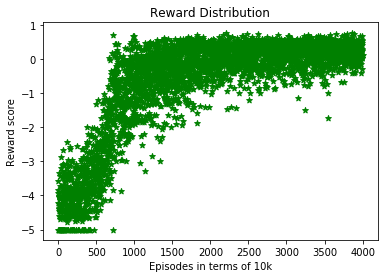

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='*') # plot points
plt.title('Reward Distribution')
plt.xlabel('Episodes in terms of 10k')
plt.ylabel('Reward score')
# ax.set_xlim(0.5, 4.5)
plt.show()

In [9]:
mean_reward=[]
for i in range( len(all_reward) - 100 ):
    mean_reward.append( mean(all_reward[i:i+100]) )

In [10]:
max_reward=[]
for i in range( len(all_reward) - 100 ):
    max_reward.append( max(all_reward[i:i+100]) )

In [11]:
min_reward=[]
for i in range( len(all_reward) - 100 ):
    min_reward.append( min(all_reward[i:i+100]) )

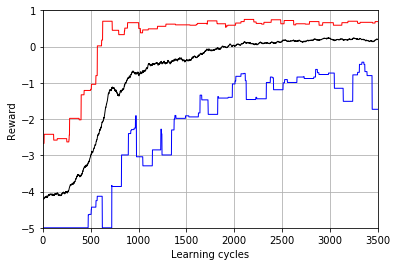

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(mean_reward)), mean_reward, color='black', linewidth=1, label = "Mean reward") # plot line
ax.plot(range(len(max_reward)), max_reward, color='red', linewidth=1, label = 'Max reward') # plot line
ax.plot(range(len(min_reward)), min_reward, color='blue', linewidth=1, label = 'Min reward') # plot line
ax.set_ylim(-5, 1)
ax.set_xlim(0, 3500)
ax.set_xlabel("Learning cycles")
ax.set_ylabel("Reward")
plt.grid(True)
plt.show()

> Check and test.

In [43]:
reach = 0
collision = 0
test_num = 3000
for i in trange( test_num ):

    state = env.reset()
    for j in range(STEP):
        action = agent.action(state) # direct action for test
        state,reward,done,info = env.step(action)
        total_reward += reward
        if done:
            # print info

            if info == "reach":
                reach += 1
            if info == "collision":
                collision += 1

            break
print( "reach: ", reach, "collision: ", collision, "other: ", ( test_num - reach - collision ) )

100%|██████████| 3000/3000 [00:15<00:00, 197.36it/s]

reach:  2950 collision:  21 other:  29


> Fetch out the push-pull states

In [44]:
reach = 0
collision = 0
for i in range(200):

    state = env.reset()
    state_0 = state.copy()
    is_push_pull = 1
    for j in range(STEP):
        action = agent.action(state) # direct action for test
        state,reward,done,info = env.step(action)
        total_reward += reward
        if done:
            # print info

            if info == "reach":
                reach += 1
                is_push_pull = 0
            elif info == "collision":
                collision += 1
                is_push_pull = 0

            break
    if is_push_pull:
        print( "state_0: ", state_0.tolist(), "\n" )
    
print( "reach: ", reach, "collision: ", collision )

state_0:  [1.7000000000000002, 1.3, -2.0, 1.8, 1.5, -1.7000000000000002] 

state_0:  [0.4, -0.2, -0.8, 0.1, 1.7000000000000002, -0.8] 

state_0:  [-1.3, -0.6000000000000001, -1.6, -1.9000000000000001, -1.3, 1.9000000000000001] 

state_0:  [-1.3, 0.1, -1.5, 1.8, -0.6000000000000001, -1.0] 

reach:  193 collision:  3


> Save model.

In [36]:
W1, b1, W2, b2, W3, b3 = agent.obtain_wb()

In [37]:
np.save('W1', W1)
np.save('W2', W2)
np.save('W3', W3)

np.save('b1', b1)
np.save('b2', b2)
np.save('b3', b3)

> Plot trajectory.

In [38]:
state_0 = np.array( [0.1, 1.5, -2.0, 1.8, 1.2000000000000002, -1.7000000000000002] )

In [39]:
reach = 0
collision = 0
for i in range( 1 ):

    state = env.reset( state_0 )
    state_0 = state.copy()
    is_push_pull = 1
    act_save = []
    trajectory = [ state[ [4,5] ].copy() ]
    for j in range(STEP):
        action = agent.action(state) # direct action for test
        act_save.append( action )
        state,reward,done,info = env.step(action)
        trajectory.append( state[ [4,5] ].copy() )
        total_reward += reward
        if done:

            if info == "reach":
                reach += 1
                is_push_pull = 0
            else:
                if info == "collision":
                    collision += 1
                    is_push_pull = 0
                else:
                    print( "state_0: ", state_0 )

            break
    if is_push_pull:
        print( "state_0: ", state_0 )
        print( "act_save: ", act_save )
    
print ("reach: ", reach, "collision: ", collision)

reach:  1 collision:  0


In [40]:
x_o = state_0[0]
y_o = state_0[1]
x_t = state_0[2]
y_t = state_0[3]
x_m = state_0[4]
y_m = state_0[5]

In [41]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

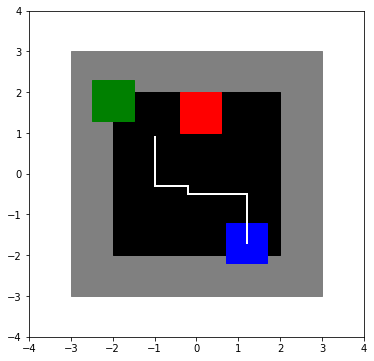

In [42]:
if True:
    fig = plt.figure( figsize=(6,6) )
    ax = fig.add_subplot(111)

    ax.add_patch(
        patches.Rectangle(
            (-3, -3),
            6,
            6,
            color="grey"
        )
    )
    ax.add_patch(
        patches.Rectangle(
            (-2, -2),
            4,
            4,
            color="black"
        )
    )
    
    ax.add_patch(
        patches.Rectangle(
            (x_o-0.5, y_o-0.5),
            1,
            1,
            color="red",
            hatch="x"
        )
    )
    
    ax.add_patch(
        patches.Rectangle(
            (x_t-0.5, y_t-0.5),
            1,
            1,
            color="green",
            hatch="+"
        )
    )
    ax.add_patch(
        patches.Rectangle(
            (x_m-0.5, y_m-0.5),
            1,
            1,
            color="blue",
            hatch="."
        )
    )
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    
    # plt.grid(True)
    
    for i in range( len(trajectory)-1 ):
        j = i+1
        # plot lines
        ax.plot( [trajectory[i][0], trajectory[j][0]], [trajectory[i][1], trajectory[j][1]] , color="white", linewidth=2)
    
    plt.show()